### Real Estate Data: Property prices, sales volumes, rental yields (Zillow - API).
#### URL: https://www.zillow.com/research/data/
This Data Exploration Analysis evaluates data available on the **Home Values** endpoint.

HOME VALUES 
 - Zillow Home Value Index (ZHVI): A measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. Available as a smoothed, seasonally adjusted measure and as a raw measure.


In [208]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
#from prophet.diagnostics import cross_validation
#from prophet.diagnostics import performance_metrics


### Single Family Home Values
**Zillow Home Value Index (ZHVI)**: 
A measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. Available as a smoothed, seasonally adjusted measure and as a raw measure.

Zillow publishes top-tier ZHVI (dollar value, typical value for homes within the 65th to 95th percentile range for a given region) and bottom-tier ZHVI (dollar value, typical value for homes within the 5th to 35th percentile range for a given region).

Zillow also publishes ZHVI for all single-family residences (dollar value, typical value for all single-family homes in a given region), for condo/coops (dollar value), for all homes with 1, 2, 3, 4 and 5+ bedrooms (dollar value), and the ZHVI per square foot (dollar value, typical value of all homes per square foot calculated by taking the estimated home value for each home in a given region and dividing it by the home’s square footage).


In [209]:
# End points for Single Family Home Values in all available geographies
# Data is provided as csv

#url_zhvi_single_family_homes_by_metro_usa = 'https://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1720392210'
#url_zhvi_single_family_homes_by_state = 'https://files.zillowstatic.com/research/public_csvs/zhvi/State_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1720392210'
url_zhvi_single_family_homes_by_county = 'https://files.zillowstatic.com/research/public_csvs/zhvi/County_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1720392210'
#url_zhvi_single_family_homes_by_city = 'https://files.zillowstatic.com/research/public_csvs/zhvi/City_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1720392210'
#url_zhvi_single_family_homes_by_zip = 'https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1720392210'
#url_zhvi_single_family_homes_by_neighborhood = 'https://files.zillowstatic.com/research/public_csvs/zhvi/Neighborhood_zhvi_uc_sfr_sm_sa_month.csv?t=1720392210'


In [210]:
# Create DataFrames 
# These are organized from widest area, an MSA, down to a Neighborhood level

#zhvi_metro_usa_df = pd.read_csv(url_zhvi_single_family_homes_by_metro_usa)
#zhvi_state_df = pd.read_csv(url_zhvi_single_family_homes_by_state)
zhvi_county_df = pd.read_csv(
    url_zhvi_single_family_homes_by_county,
    parse_dates=True,
    infer_datetime_format=True
    )
#zhvi_city_df = pd.read_csv(url_zhvi_single_family_homes_by_city)
#zhvi_zip_df = pd.read_csv(url_zhvi_single_family_homes_by_zip)
#zhvi_neighborhood_df = pd.read_csv(url_zhvi_single_family_homes_by_neighborhood)

/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_61361/3359857595.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  zhvi_county_df = pd.read_csv(


In [211]:
# Review the columns
print(f"County: {zhvi_county_df.columns}")

County: Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS', '2000-01-31',
       ...
       '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
       '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30'],
      dtype='object', length=303)


In [212]:
zhvi_county_df.dtypes

RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-02-29    float64
2024-03-31    float64
2024-04-30    float64
2024-05-31    float64
2024-06-30    float64
Length: 303, dtype: object

In [213]:
# look at County Data
print(zhvi_county_df.head())
#print(zhvi_county_df.tail())


   RegionID  SizeRank          RegionName RegionType StateName State  \
0      3101         0  Los Angeles County     county        CA    CA   
1       139         1         Cook County     county        IL    IL   
2      1090         2       Harris County     county        TX    TX   
3      2402         3     Maricopa County     county        AZ    AZ   
4      2841         4    San Diego County     county        CA    CA   

                                  Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0    Los Angeles-Long Beach-Anaheim, CA              6                 37   
1    Chicago-Naperville-Elgin, IL-IN-WI             17                 31   
2  Houston-The Woodlands-Sugar Land, TX             48                201   
3             Phoenix-Mesa-Chandler, AZ              4                 13   
4    San Diego-Chula Vista-Carlsbad, CA              6                 73   

      2000-01-31  ...     2023-09-30     2023-10-31     2023-11-30  \
0  223227.570289  ...  908470.1641

In [214]:
# Clean up the dataframe
# List of columns
all_columns = zhvi_county_df.columns.tolist()

# Checking if columns are floats
date_columns = [col for col in all_columns if 'float' in str(zhvi_county_df[col].dtype)]

# List of non-date columns to keep
state_county_columns = ['StateName', 'RegionName']

# Combine the columns with the date columns
my_columns = state_county_columns + date_columns

# Create a new DataFrame
my_df = zhvi_county_df[my_columns]

# Rename columns
my_df = my_df.rename(columns={'StateName': 'State', 'RegionName': 'County'})

my_df

,State,County,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,...,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30
0,CA,Los Angeles County,223227.570289,223475.558103,224398.752822,226220.795074,228541.710126,230769.287943,233021.097624,235338.515611,...,908470.164191,920227.893039,929015.843494,934548.891149,933373.048335,928068.136342,923865.536315,9.247795e+05,9.284306e+05,9.309001e+05
1,IL,Cook County,155001.856326,154956.889046,155194.296699,155896.267957,156782.004013,157706.818363,158555.069253,159824.191164,...,318401.265838,319825.649452,320807.462970,321484.462541,322011.240173,323401.039876,326043.702340,3.292884e+05,3.316914e+05,3.331743e+05
2,TX,Harris County,113426.768603,113390.825350,113216.599823,113145.984611,113119.303441,113316.839873,113522.423163,113828.931296,...,290095.008822,290139.115275,289887.928358,289601.583693,289719.518949,290207.306644,291249.723603,2.923441e+05,2.929599e+05,2.928385e+05
3,AZ,Maricopa County,147617.388832,147922.660622,148320.805635,149135.836919,150032.908914,150799.084098,151568.120033,152287.580862,...,473709.417278,475960.153050,477802.198730,478802.388963,479165.533584,479740.411788,481323.229115,4.832995e+05,4.848863e+05,4.851605e+05
4,CA,San Diego County,229910.294473,230825.004517,231920.619014,234394.285903,237039.765022,240376.705795,244201.730335,248389.313312,...,951680.611779,961908.232012,968876.125006,972538.358823,974985.819772,980208.456178,989791.934438,1.001835e+06,1.012124e+06,1.017484e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,NE,Banner County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,324386.781546,328189.047205,330313.999936,330790.287018,329480.077032,328214.717676,329666.211162,3.325357e+05,3.357770e+05,3.362624e+05
3072,UT,Daggett County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,323170.813759,322275.233917,321534.602732,320826.655822,321465.054748,322333.093005,3.224145e+05,3.210638e+05,3.188373e+05
3073,NE,Thomas County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,147427.189248,146902.019191,146712.980263,146487.967325,146664.105500,1.471023e+05,1.474207e+05,1.477647e+05
3074,NE,McPherson County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,278737.403650,281969.387498,284199.279875,286169.040695,287759.975190,289710.423185,293416.154727,2.986277e+05,3.029513e+05,3.051740e+05


In [215]:
# Count the number of counties per state
counties_per_state = my_df.groupby('State').size()
sorted_counties_per_state = counties_per_state.sort_values(ascending=False)
print(sorted_counties_per_state.head())
print(sorted_counties_per_state.tail())

State
TX    243
GA    159
VA    133
KY    120
MO    115
dtype: int64
State
CT    8
RI    5
HI    4
DE    3
DC    1
dtype: int64


In [216]:
# Counties with the Biggest Growth
# Compounded Annual Growth Rate (CAGR) for each County
# CAGR = ((ending value / starting value) ** 1/num of yrs) -1  

# Select start and end dates of analysis in YYYY-MM-DD format
# monthly data as 2000-01-31 to 2024-06-30
start_date = '2010-06-30'
end_date = '2024-06-30' 

# Determine the number of years between start and end dates
num_years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365

# Calculate CAGR as a percent
my_df['CAGR'] = (((my_df[end_date] / my_df[start_date]) ** (1 / num_years)) - 1) * 100

# Clean up the list
home_value_CAGR = my_df[['State', 'County', 'CAGR']].sort_values(by='CAGR', ascending=False)
home_value_CAGR = home_value_CAGR.reset_index(drop=True)
home_value_CAGR['County_State'] = home_value_CAGR['County'] + ', ' + home_value_CAGR['State']
home_value_CAGR
home_value_CAGR = home_value_CAGR[['County_State', 'CAGR']]
home_value_CAGR.head(100)

,County_State,CAGR
0,"Petersburg City, VA",11.300335
1,"Clayton County, GA",10.520823
2,"Hendry County, FL",9.936784
3,"Saint Lucie County, FL",9.839267
4,"Newton County, GA",9.473919
...,...,...
95,"Ravalli County, MT",7.450150
96,"Sarasota County, FL",7.417851
97,"Jefferson County, MT",7.398768
98,"Sevier County, TN",7.365726


In [217]:
#home_value_CAGR.shape
#home_value_CAGR.tail()
home_value_CAGR.to_csv('home_value_CAGR.csv', index=False)


In [218]:
# States with the Biggest Growth
# Calculate the average CAGR per state
average_cagr_per_state = my_df.groupby('State')['CAGR'].mean()

# Sort states by average CAGR from highest to lowest
sorted_states_by_growth = average_cagr_per_state.sort_values(ascending=False)

# Print the sorted states by growth
sorted_states_by_growth.head(10)

State
UT    6.995336
ID    6.908656
MT    6.764786
FL    6.628676
CO    6.426902
NV    6.271817
HI    6.137664
TN    6.115867
AZ    6.102797
CA    6.065065
Name: CAGR, dtype: float64

                 County_State       CAGR
0         Petersburg City, VA  11.300335
1          Clayton County, GA  10.520823
2           Hendry County, FL   9.936784
3      Saint Lucie County, FL   9.839267
4           Newton County, GA   9.473919
5        Jefferson County, OR   9.471988
6           Canyon County, ID   9.421869
7          Carroll County, GA   9.343086
8            Teton County, WY   9.323335
9        Wyandotte County, KS   9.091360
10           Boise County, ID   8.916550
11            Lyon County, NV   8.844339
12          Merced County, CA   8.790245
13           Crook County, OR   8.774285
14         Payette County, ID   8.700562
15      Miami-Dade County, FL   8.630035
16          Summit County, UT   8.594163
17           Heard County, GA   8.538946
18          Jasper County, GA   8.391737
19           Pinal County, AZ   8.375412
20             Lee County, FL   8.354128
21     San Joaquin County, CA   8.321528
22         Osceola County, FL   8.311894
23          Vall

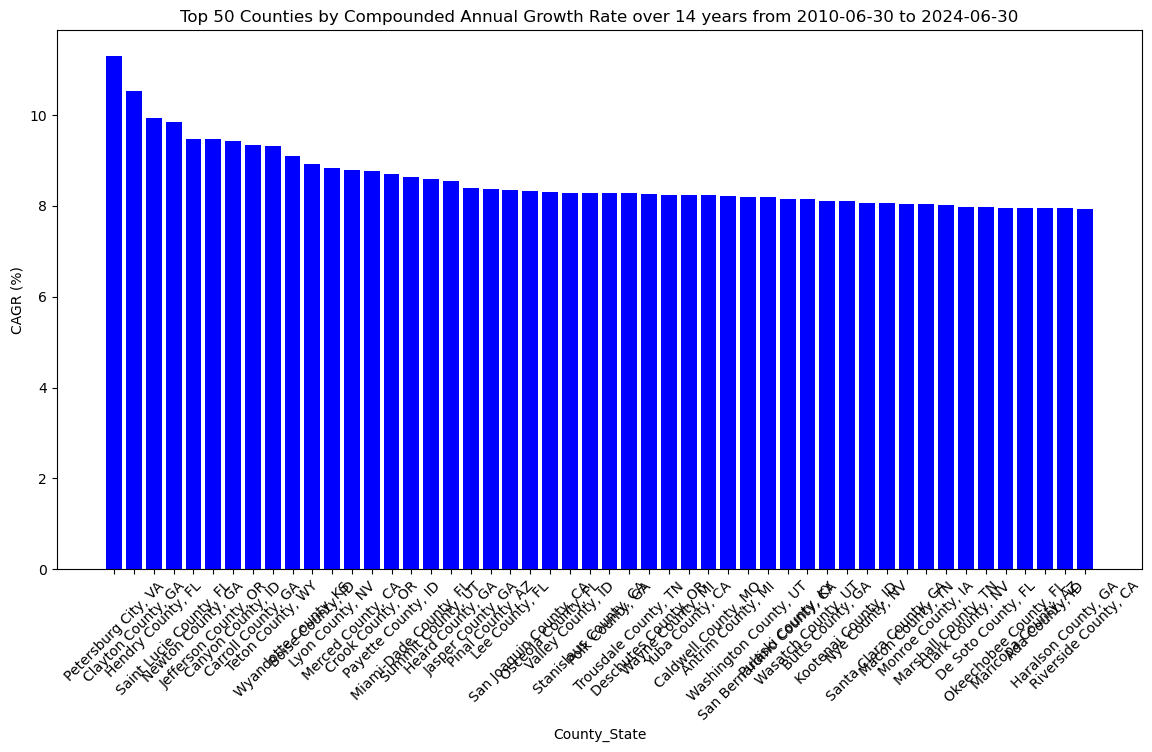

In [219]:
# top counties for visualization
n = 50 # number of counties to display
top_counties = home_value_CAGR.head(n)
print(top_counties)

# Create the bar chart
plt.figure(figsize=(14, 7))
plt.bar(top_counties['County_State'], top_counties['CAGR'], color='blue')

# Add titles and labels
plt.title(f'Top {n} Counties by Compounded Annual Growth Rate over {int(num_years)} years from {start_date} to {end_date}')
plt.xlabel('County_State')
plt.ylabel('CAGR (%)')

# Improve layout to better fit county names if necessary
plt.xticks(rotation=45)  # Rotate the x labels to fit longer names

# Display the plot
plt.show()

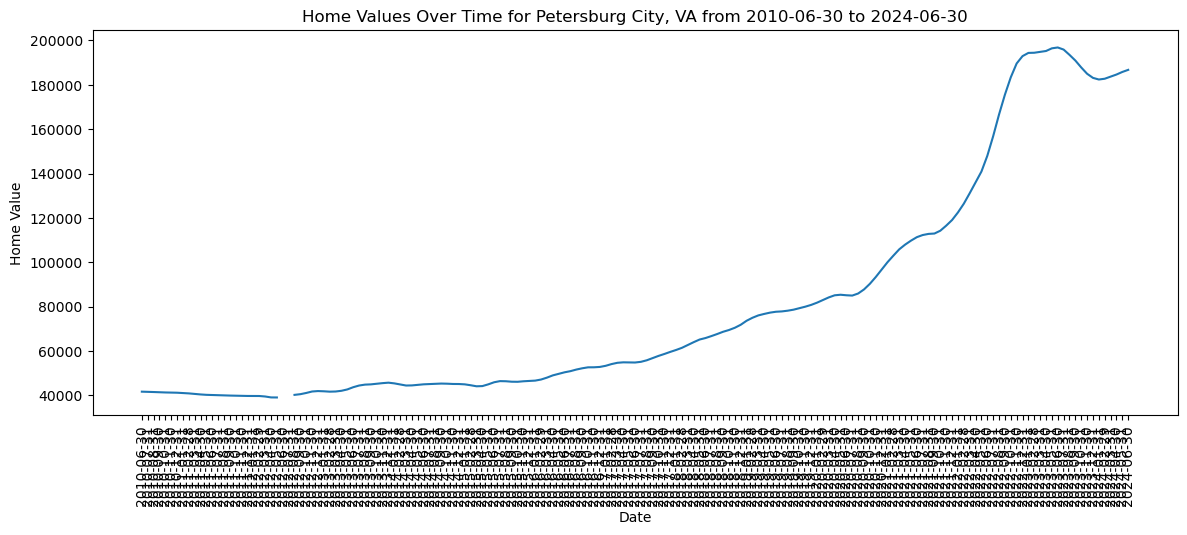

In [220]:
# Extract the 'County_State' information
index_of_county = 0
county_state = top_counties.iloc[index_of_county]['County_State']
county, state = county_state.split(', ')
#print(county)

# Filter for the matching county and state
filtered_row = my_df[(my_df['County'] == county) & (my_df['State'] == state)]

# Identifying and selecting columns that are within the date range
date_columns = [col for col in filtered_row.columns if col not in ['State', 'County', 'CAGR']]
valid_dates = [col for col in date_columns if start_date <= col <= end_date]

# Select the data for plotting
plot_data = filtered_row[valid_dates].transpose()
plot_data.columns = ['Values']  # Renaming the column to help in plotting

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(plot_data.index, plot_data['Values'], linestyle='-')
plt.title(f'Home Values Over Time for {county}, {state} from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.xticks(rotation=90)  # Rotate date labels 
plt.grid(False)
plt.show()

In [221]:
# Prepare data for Prophet
train_set = plot_data.copy()
train_set.reset_index(inplace=True)  # Make the index into a column
train_set.columns = ['ds', 'y']  # Rename columns to what Prophet expects

# Display the new DataFrame ready for Prophet
print(train_set.head())

           ds             y
0  2010-06-30  41667.490140
1  2010-07-31  41606.278609
2  2010-08-31  41504.800845
3  2010-09-30  41388.029675
4  2010-10-31  41308.265441


21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, c

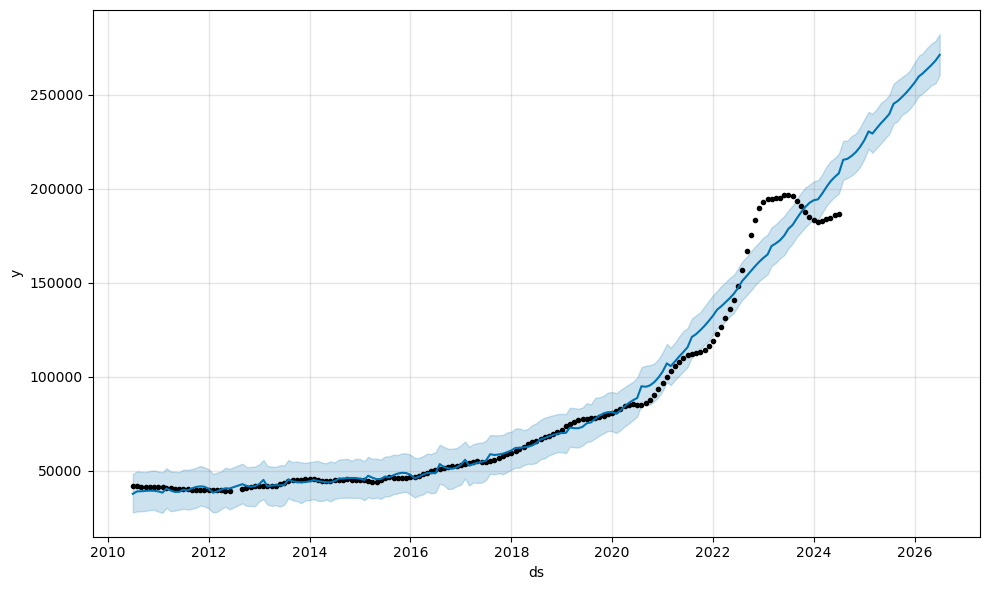

In [222]:
 # Fit the Prophet model
model_index0 = Prophet()
model_index0.fit(train_set)

# Future dataframe for 2 years ahead, specifying 24 monthly periods
future_dates = model_index0.make_future_dataframe(periods=24, freq='M')

# Predict future values
forecast = model_index0.predict(future_dates)

# Plot the forecast
fig_0_1 = model_index0.plot(forecast)

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

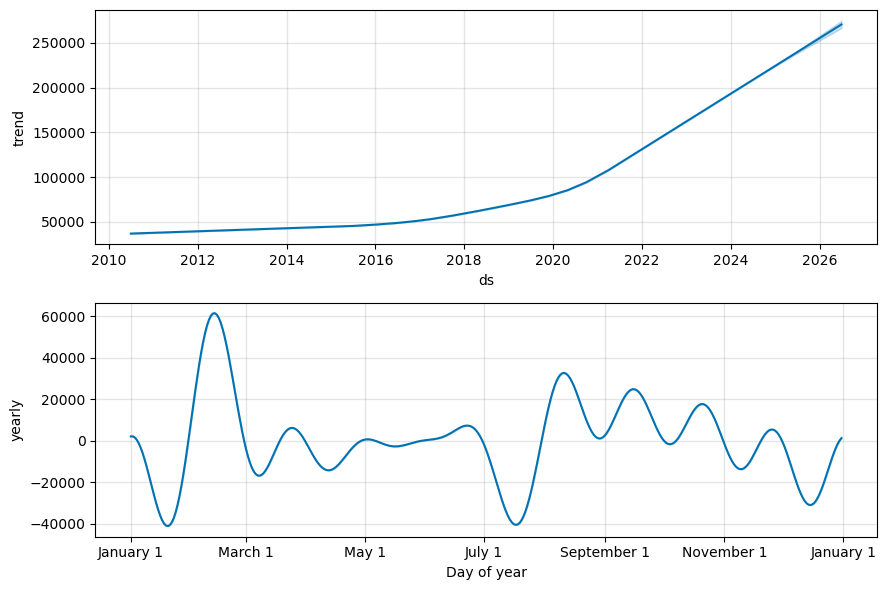

In [223]:
# Plot the components of the forecast
fig_0_2 = model_index0.plot_components(forecast)

In [224]:
# Try and use RegionID as a key across datasets

# Extract the 'RegionID' for the specified county and state and use it to find New Construction Sales Counts
region_id = zhvi_county_df.loc[(zhvi_county_df['RegionName'] == county) & (zhvi_county_df['StateName'] == state), 'RegionID']

# As loc might return a Series if there are multiple matches, we typically take the first value if we expect unique matches
region_id = region_id.iloc[0] if not region_id.empty else None

# Output the result
print("RegionID:", region_id)

RegionID: 3259


In [225]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model_index0, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

  0%|          | 0/23 [00:00<?, ?it/s]

21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-08-31,38100.964891,38033.199964,38166.969719,40222.902855,2012-08-27
1,2012-09-30,37348.056633,37135.690712,37567.154010,40531.767973,2012-08-27
2,2012-10-31,37045.363792,36617.411465,37451.509743,41082.527011,2012-08-27
3,2012-11-30,37318.476682,36629.778588,37960.830825,41742.247706,2012-08-27
4,2012-12-31,36980.417522,35979.067192,37900.997011,41934.718455,2012-08-27


In [226]:
cutoffs = pd.to_datetime(['2016-01-31', '2018-01-31', '2020-01-31'])
df_cv2 = cross_validation(model_index0, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing


In [227]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
#df_p.head()
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
191,358 days,5.196564e+08,22795.973185,14066.646308,0.113100,0.082417,0.120798,0.222222
192,359 days,5.541518e+08,23540.429879,14488.667805,0.111563,0.082417,0.119340,0.259259
193,363 days,4.363551e+08,20889.113800,12809.828631,0.100873,0.078485,0.106239,0.296296
194,364 days,4.370742e+08,20906.320532,12942.098574,0.102743,0.078485,0.108191,0.259259
195,365 days,4.824441e+08,21964.610474,13414.667321,0.105681,0.078485,0.108829,0.259259


/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


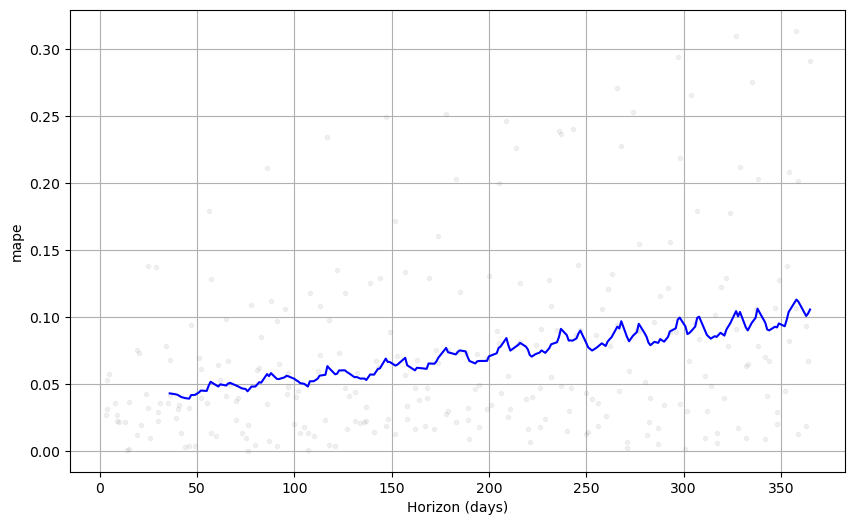

In [228]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [229]:
# Start investigation for tuning the model
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None, scaling: str = 'absmax', holidays_mode=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_